In [23]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib.py','wb').write(src)
import mylib

Saving problem_unittests.py to problem_unittests (1).py


In [0]:
data_dir = 'image/Face'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests

%matplotlib inline

In [25]:
import torch
from torchvision import datasets
from torchvision import transforms
from google.colab import drive
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def get_dataloader(batch_size, image_size, data_dir='/content/gdrive/My Drive/image/'):

    transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor()])
    data = datasets.ImageFolder(data_dir,transform = transform)
    
    dataLoader = torch.utils.data.DataLoader(data,batch_size = batch_size, shuffle= True)
    
    return dataLoader

In [0]:
batch_size = 64
img_size = 32

celeba_train_loader = get_dataloader(batch_size, img_size)

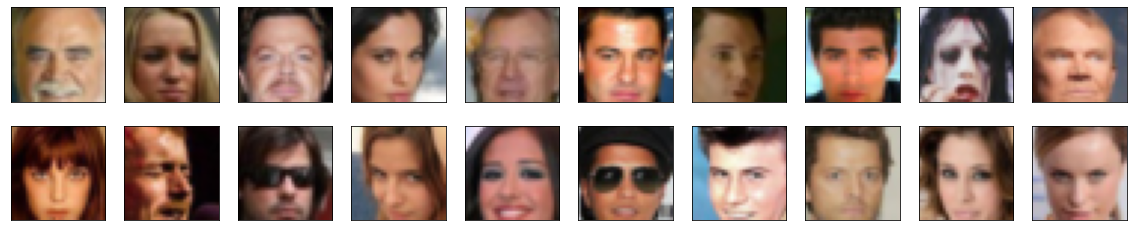

In [28]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(celeba_train_loader)
images, _ = dataiter.next()
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [0]:
def scale(x, feature_range=(-1, 1)):
    x = x*2 - 1
    return x

In [30]:
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9137)
Max:  tensor(0.8824)


In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
def conv(in_channels,out_channels,kernel_size=4,stride = 2,padding=1,batch_norm = True):
  
    layer = list()
    layer.append(nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding))
  
    if(batch_norm):
        layer.append(nn.BatchNorm2d(out_channels))
  
    return nn.Sequential(*layer)

In [33]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):

        self.conv_dim  = conv_dim
        
        super(Discriminator, self).__init__()

        self.conv1 = conv(3,conv_dim,4,2)     
        self.conv2 = conv(conv_dim,conv_dim*2,4,2)    
        self.conv3 = conv(conv_dim*2,conv_dim*4,4,2)   
        self.conv4 = conv(conv_dim*4,conv_dim*8,4,2,batch_norm=False)  
        
        self.fc1 = nn.Linear(2*2*conv_dim*8,512)
        self.fc2 = nn.Linear(512,1)
        
        self.drp = nn.Dropout(0.3)

    def forward(self, x):

        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        
        x = x.reshape(-1,2*2*self.conv_dim*8)
        x = F.leaky_relu(self.fc1(x))
        x = self.drp(x)
        x = self.fc2(x)
        
        return x

tests.test_discriminator(Discriminator)

Tests Passed


In [0]:
def deconv(in_channels,out_channels,kernel_size=4,stride = 2,padding=1,batch_norm = True):
  
    layer = list()
    layer.append(nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding))

    if(batch_norm):
        layer.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layer)

In [35]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):

        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim = 1024
        self.fc1 = nn.Linear(z_size,1*1*conv_dim)
        
        self.conv1 = deconv(conv_dim,conv_dim//2,4,2)     
        self.conv2 = deconv(conv_dim//2,conv_dim//4)           
        self.conv3 = deconv(conv_dim//4,conv_dim//8)            
        self.conv4 = deconv(conv_dim//8,conv_dim//16)            
        self.conv5 = deconv(conv_dim//16,3,batch_norm = False)  

    def forward(self, x):
        
        x = F.leaky_relu(self.fc1(x))
        x = x.reshape(-1,self.conv_dim,1,1)
        
        x = F.leaky_relu(self.conv1(x))
        
        x = F.leaky_relu(self.conv2(x))
        
        x = F.leaky_relu(self.conv3(x))
        
        x = F.leaky_relu(self.conv4(x))
        
        x = torch.tanh(self.conv5(x))
        
        
        return x

tests.test_generator(Generator)

Tests Passed


In [0]:
def weights_init_normal(m):

    classname = m.__class__.__name__
    
    if classname.find('Linear') != -1 or classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
     

In [0]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [38]:
d_conv_dim = 64
g_conv_dim = 1024
z_size = 100 

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (drp): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=1024, bias=True)
  (conv1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel

In [39]:
import torch

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


In [0]:
def real_loss(D_out):

    criterian = nn.BCEWithLogitsLoss()
    target = torch.ones(*D_out.shape)
    
    if train_on_gpu:
        target = target.cuda()
    loss = criterian(D_out,target)
    return loss

def fake_loss(D_out):

    criterian = nn.BCEWithLogitsLoss()
    target = torch.zeros(*D_out.shape)
    
    if train_on_gpu:
        target = target.cuda()
    loss = criterian(D_out,target)
    return loss

In [0]:
import torch.optim as optim

d_optimizer = optim.Adam(D.parameters(),lr = 0.0002)
g_optimizer = optim.Adam(G.parameters(),lr = 0.0002)

In [0]:
def train(D, G, n_epochs, print_every=50):

    if train_on_gpu:
        D.cuda()
        G.cuda()

    samples = []
    losses = []

    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()

    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    for epoch in range(n_epochs):

        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            d_out = D(real_images)
            d_real_loss = real_loss(d_out)
            
            z = np.random.uniform(-1, 1, size=(sample_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_out = G(z)
            
            g_fake_loss = fake_loss(D(fake_out))
            
            d_loss = d_real_loss + g_fake_loss 
            d_loss.backward()
            d_optimizer.step()

            g_optimizer.zero_grad()
            
            g_out = G(z)
            d_real_out = D(g_out)
            g_loss = real_loss(d_real_out)
            
            g_loss.backward()
            g_optimizer.step()

            if batch_i % print_every == 0:
                losses.append((d_loss.item(), g_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))

        G.eval()
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()

    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    return losses

In [43]:
n_epochs = 10

losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   10] | d_loss: 1.4780 | g_loss: 1.1575
Epoch [    1/   10] | d_loss: 0.0168 | g_loss: 12.1562
Epoch [    2/   10] | d_loss: 0.1864 | g_loss: 30.9086
Epoch [    2/   10] | d_loss: 0.0979 | g_loss: 8.2896
Epoch [    3/   10] | d_loss: 0.0081 | g_loss: 11.5249
Epoch [    3/   10] | d_loss: 0.9296 | g_loss: 39.2069
Epoch [    4/   10] | d_loss: 0.2694 | g_loss: 24.0275
Epoch [    4/   10] | d_loss: 0.0474 | g_loss: 7.7112
Epoch [    5/   10] | d_loss: 0.0088 | g_loss: 8.8416
Epoch [    5/   10] | d_loss: 0.1575 | g_loss: 4.8505
Epoch [    6/   10] | d_loss: 0.0487 | g_loss: 6.6012
Epoch [    6/   10] | d_loss: 0.0695 | g_loss: 5.2340
Epoch [    7/   10] | d_loss: 0.0024 | g_loss: 11.6240
Epoch [    7/   10] | d_loss: 0.0851 | g_loss: 8.3634
Epoch [    8/   10] | d_loss: 0.0148 | g_loss: 7.4822
Epoch [    8/   10] | d_loss: 0.0276 | g_loss: 11.1472
Epoch [    9/   10] | d_loss: 0.0021 | g_loss: 10.3924
Epoch [    9/   10] | d_loss: 0.0118 | g_loss: 7.0064
Epoch [   10/   10] 

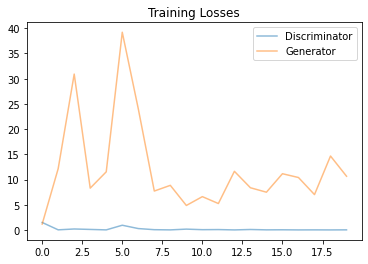

In [44]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [0]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [0]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

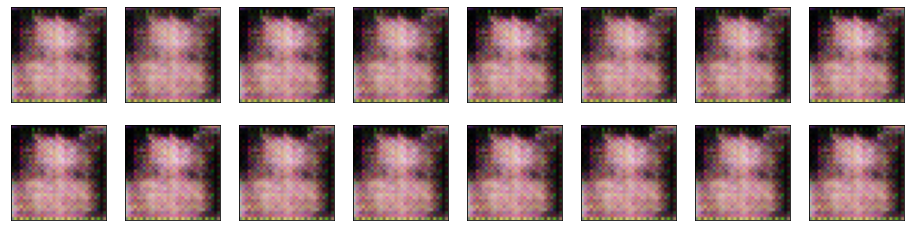

In [47]:
_ = view_samples(-1, samples)